In [20]:
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import Normalize, Compose
from pathlib import *
import os
import matplotlib.pyplot as plt

from utils.StackingDataset import StackingDataset  # Assuming you saved the custom dataset class in a file named custom_dataset.py
from models.simple_cnn import SimpleCNN  # Assuming you saved the custom CNN class in a file named custom_cnn.py
from models.resnet import ResNet18


transform = Compose([
    Normalize(mean=[174.7335,   0.9116], std=[108.9636,   0.1411])
])

output_transform = {
    "mean": torch.Tensor([ 5.5213e+01,  6.9066e-04, -5.0562e-03, -2.7119e-02]),
    "std": torch.Tensor([1.5544, 0.2182, 0.2224, 0.2800])
}


curr_dir = os.getcwd() #os.path.dirname( os.path.abspath(__file__) )
home_path = Path(curr_dir).parent.absolute()
dataset_path = os.path.join(home_path, "nanodrones_sim", "data")
weights_path = os.path.join(home_path, "imitation_learning_simple", "weights")

dataset = StackingDataset(csv_dir=dataset_path, transform=transform)


# Split dataset into train, validation, and test sets
train_ratio = 0.7
val_ratio = 0.2

train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = ResNet18()
model.load_state_dict(torch.load(
    os.path.join(home_path, 'imitation_learning_simple', 'weights', 'resnet_best.pth')
    ))
model.to(device)

all_labels = []
all_outputs = []

test_loader = DataLoader(test_dataset, batch_size=16)
with torch.no_grad():
    for images, labels in test_loader:
        labels = (labels - output_transform['mean']) / output_transform['std']
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        labels = labels.cpu()
        outputs = outputs.cpu()
        for x in labels: all_labels.append(x) 
        for x in outputs: all_outputs.append(x) 

all_labels = np.array(all_labels)
all_outputs = np.array(all_outputs)


cuda


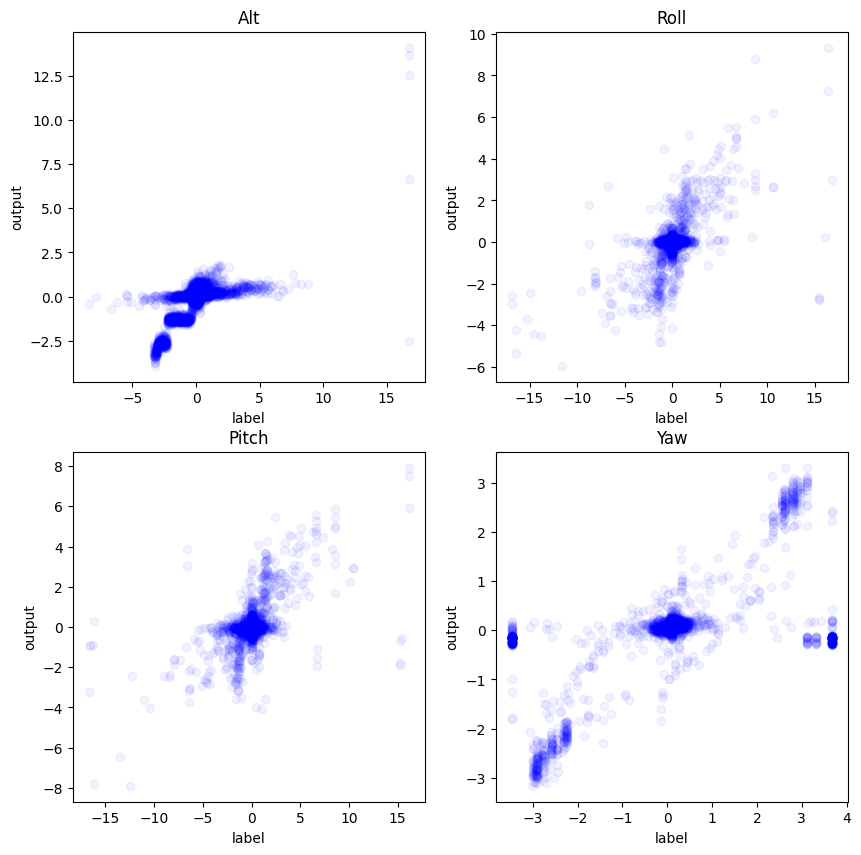

In [31]:
plt.rcParams['figure.figsize'] = (10, 10)
fig, axs = plt.subplots(2, 2)

axs[0, 0].set_title('Alt')
axs[0, 1].set_title('Roll')
axs[1, 0].set_title('Pitch')
axs[1, 1].set_title('Yaw')

for i in [0,1]:
    for j in [0,1]:
        axs[i,j].set_xlabel("label")
        axs[i,j].set_ylabel("output")


axs[0,0].scatter(all_labels[:, 0], all_outputs[:, 0], color='blue', alpha=0.05)
axs[0,1].scatter(all_labels[:, 1], all_outputs[:, 1], color='blue', alpha=0.05)
axs[1,0].scatter(all_labels[:, 2], all_outputs[:, 2], color='blue', alpha=0.05)
axs[1,1].scatter(all_labels[:, 3], all_outputs[:, 3], color='blue', alpha=0.05)

plt.show()


In [25]:
from sklearn.metrics import r2_score

for i in range(4):
    print(f"R2 Score on output {i}: ", r2_score(all_labels[:,i], all_outputs[:, i]))

0.5350965267388084
0.3341189751207737
0.29733238606965284
0.31156689406502924
